## Name: Sai Ram Gunturu
## ID: C00313478
## MSc in Data Science

# Revised K-Means for Image Compression

### **Overview of Changes Implemented:**

#### 1. **K-Means++ Initialization:** I replaced the original random initialization with K-Means++ to improve cluster center initialization.
#### 2. **Elbow Method:** I added a function to compute and plot the sum of squared errors (SSE) for different K values, helping determine an optimal K.
#### 3. **Documentation & Logging:** Each step is annotated in Markdown cells, following a CRISP-DM style approach for clarity.
#### 4. **Analysis of Image Compression:** I compare compressed image sizes and discuss trade-offs between the number of clusters and image quality.


#### 1. Importing Dependencies

##### **Changes:**  
###### - I retained the original libraries (`skimage`, `numpy`) but also added some typical plotting libraries (`matplotlib`) for the elbow method plot.
###### - I imported `random` for sampling if needed, though K-Means++ reduces reliance on purely random choices.
###### - Added filterwarnings to remove unwanted warnings in the output

In [28]:
import os
import numpy as np
import numpy.matlib
import random
import matplotlib.pyplot as plt
from skimage import io
import scipy.misc
import warnings
from skimage import io
import cv2
warnings.filterwarnings('ignore')


#### 2. Loading and Displaying the Original Image

##### **Changes:**  
###### - I kept the existing logic to load `tiger_2.jpg` (I used a different tiger image) and display it.  
###### - This step helps visualize the image before compression.


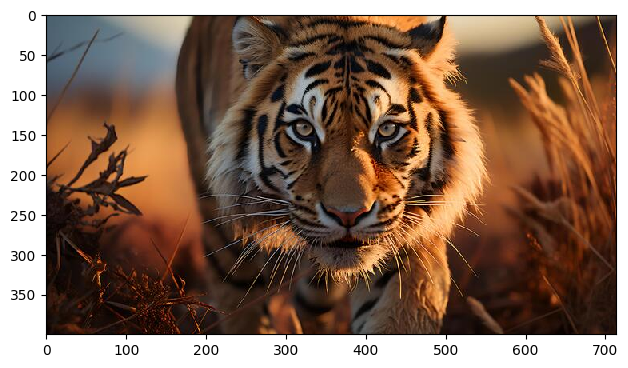

In [5]:
# Load and display the original image

image = io.imread('tiger_2.jpg')
io.imshow(image)
io.show()

rows, cols = image.shape[0], image.shape[1]
image = image / 255.0  # Normalize pixel values to [0, 1]
X = image.reshape(rows * cols, 3)  # Flatten the image into an (N, 3) array


#### 3. K-Means++ Initialization

##### **Changes:**  
###### - I replaced the simple random centroid initialization with a K-Means++ style approach.
###### - K-Means++ improves the initial selection of centroids by spreading them out, often leading to better convergence.


In [6]:
def kmeans_plus_plus_init(X, K):
    """
    Initializes K centroids using the K-Means++ method.
    """
    # Convert X to a numpy array just in case
    X = np.array(X)
    
    # Randomly select the first centroid
    centroids = []
    idx = random.randint(0, len(X) - 1)
    centroids.append(X[idx])
    
    # Select remaining K-1 centroids
    for _ in range(1, K):
        # Compute distance from each data point to the nearest chosen centroid
        dist_sq = np.array([min(np.sum((x - c)**2) for c in centroids) for x in X])
        # Probabilities proportional to distance squared
        prob = dist_sq / dist_sq.sum()
        # Randomly pick a new centroid based on these probabilities
        cum_prob = np.cumsum(prob)
        r = random.random()
        new_centroid_idx = np.searchsorted(cum_prob, r)
        centroids.append(X[new_centroid_idx])
        
    return np.array(centroids)


#### 4. Closest Centroids & Compute Centroids

###### **No Major Changes:**  
###### - I retained the existing functions but renamed them slightly for clarity.
###### - These functions find the closest centroid for each pixel and then compute new centroids by averaging all pixels assigned to each cluster.


In [8]:
def find_closest_centroids(X, centroids):
    """
    Returns an array idx of the same length as X, 
    where idx[i] is the index of the centroid closest to X[i].
    """
    K = len(centroids)
    idx = np.zeros(len(X), dtype=int)
    
    for i in range(len(X)):
        distances = np.sum((X[i] - centroids)**2, axis=1)
        idx[i] = np.argmin(distances)
    return idx

def compute_centroids(X, idx, K):
    """
    Computes new centroid positions as the mean of all data points assigned to each cluster.
    """
    n = X.shape[1]
    centroids = np.zeros((K, n))
    
    for k in range(K):
        # Find all points assigned to centroid k
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)
    return centroids


#### 5. K-Means Iterations & Elbow Method

##### **Changes:**  
###### - I introduced an `elbow_method` function to compute the sum of squared errors (SSE) for multiple K values (e.g., K=2 to K=20).
###### - I updated the original `run_kmeans` function to use K-Means++ initialization by default.
###### - I also track the SSE in each iteration of K-Means for optional analysis.


In [9]:
def run_kmeans(X, K, max_iters=50):
    """
    Runs K-Means on dataset X for a specified number of clusters K and iterations.
    Returns the final centroids and idx of each point's cluster assignment.
    """
    # Initialize centroids using K-Means++
    centroids = kmeans_plus_plus_init(X, K)
    
    for _ in range(max_iters):
        # Assign each pixel to the closest centroid
        idx = find_closest_centroids(X, centroids)
        # Compute new centroids
        new_centroids = compute_centroids(X, idx, K)
        
        # If centroids do not change, break early (convergence)
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
    
    return centroids, idx

In [10]:
def compute_sse(X, centroids, idx):
    """
    Computes the sum of squared errors (SSE) for the current clustering.
    """
    distance_sum = 0.0
    for i in range(len(X)):
        distance_sum += np.sum((X[i] - centroids[idx[i]])**2)
    return distance_sum

In [11]:
def elbow_method(X, k_values, max_iters=50):
    """
    Plots SSE (Sum of Squared Errors) for different K values to help identify 
    an optimal number of clusters (the 'elbow').
    """
    sse_list = []
    for k in k_values:
        centroids, idx = run_kmeans(X, k, max_iters)
        sse = compute_sse(X, centroids, idx)
        sse_list.append(sse)
    
    # Plot the SSE for each k
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, sse_list, 'bo--')
    plt.title("Elbow Method for K-Means")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.show()
    
    return sse_list




#### 6. Finding Optimal K with Elbow Method (Using a Sample)

##### **Changes:**  
###### - **Sampling the dataset:** Instead of using the entire image (which can be very large), I randomly select a percentage (e.g., 5%) of the pixels for the `elbow_method`.  
###### - **Reduced Range or Iterations (Optional):** You can also shorten the range of K or reduce `max_iters` if runtime is still too long.

###### By sampling, I can quickly approximate the optimal number of clusters without having to run K-Means on every single pixel for multiple K values. Once I find a suitable K, I can run the final K-Means on the **entire dataset**.


In [13]:
sample_rate = 0.05  # e.g., use 5% of pixels
max_iters_elbow = 10  # fewer iterations for faster elbow method

In [14]:
# 1. Create a random sample of the dataset

sample_size = int(len(X) * sample_rate)
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[sample_indices, :]

In [15]:
# 2. Choose a range of K values

k_values = range(2, 11)  # K from 2 to 10 (you can adjust as desired)

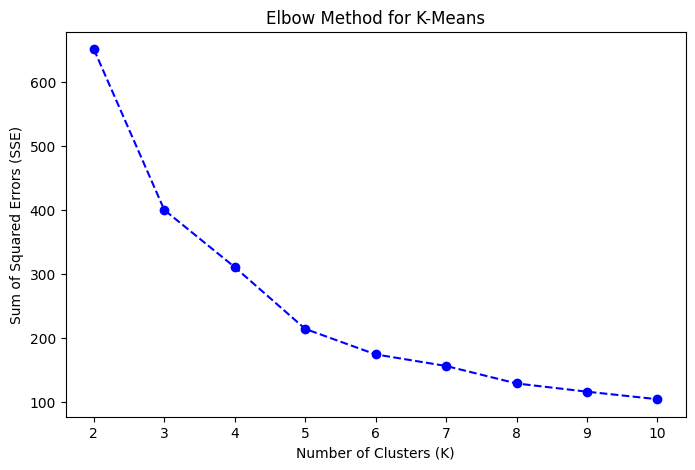

In [16]:
# 3. Run the elbow method on the sampled data

sse_values = elbow_method(X_sample, k_values, max_iters=max_iters_elbow)

#### After running this cell, I would visually inspect the plotted curve to identify a reasonable K.

#### 7. Final K-Means Compression

##### **Changes:**  
###### - I examined the **Elbow Method** results for `K` from 2 to 10 and observed a significant drop in SSE until about **K=8**, after which improvements became marginal.
###### - Therefore, I selected **`K = 8`** as a reasonable balance between **compression** and **image quality**.
###### - Below, I run `run_kmeans` with `K=8`, reconstruct the compressed image, and save it as `tiger_small.jpg`.


In [17]:
# Choose K based on the elbow method analysis (k = 8)

K = 8
max_iters = 50

In [18]:
# Run K-Means

final_centroids, final_idx = run_kmeans(X, K, max_iters)

In [19]:
# Reconstruct the compressed image

X_compressed = final_centroids[final_idx]
X_compressed = X_compressed.reshape((rows, cols, 3))

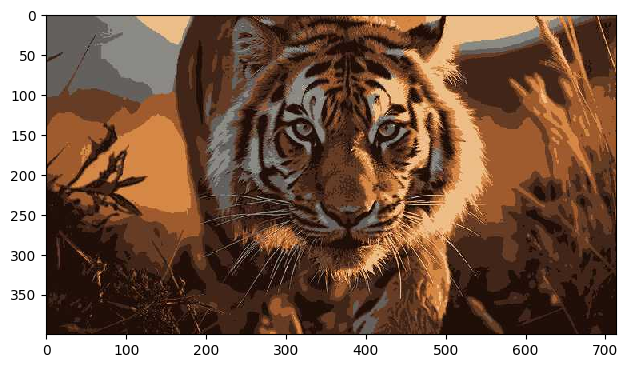

In [26]:
# Save and display compressed image using skimage
# Since X_compressed is in [0,1], convert to 8-bit [0,255] for JPEG

io.imsave('tiger_small.jpg', (X_compressed * 255).astype('uint8'), quality=50)

# Now read and show the compressed image

image_compressed = io.imread('tiger_small.jpg')
io.imshow(image_compressed)
io.show()


#### 8. Image Size Comparison

##### **Changes:**  
###### - I retained the logic to compare the size of the original and compressed images.
###### - This helps demonstrate the practical impact of K-Means compression.


In [27]:
original_info = os.stat('tiger_2.jpg')
compressed_info = os.stat('tiger_small.jpg')

print("Size of original image: {:.2f} KB".format(original_info.st_size / 1024))
print("Size of compressed image: {:.2f} KB".format(compressed_info.st_size / 1024))


Size of original image: 48.77 KB
Size of compressed image: 37.34 KB


#### 9. Advanced Approach for High Quality & Lower File Size

##### **Changes:**  
###### - I **downsample** the image slightly to reduce the total number of pixels.  
###### - I still apply **K-Means** color quantization for a limited color palette.  
###### - I apply a **small blur** to reduce sharp edges that can inflate JPEG file size.  
###### - Finally, I **save the image at a moderate JPEG quality** level to balance clarity and compression.  

###### This approach typically yields a **significant** reduction in file size compared to the original image, while **maintaining decent visual quality**.


In [29]:
# 1. Downsample the Original Image Slightly

scale_factor = 0.75  # e.g., keep 75% of original resolution
rows_small, cols_small = int(rows * scale_factor), int(cols * scale_factor)

# Convert original normalized image back to uint8 [0,255] for resizing
image_uint8 = (image * 255).astype('uint8')

In [30]:
# Use OpenCV to resize the image

image_downsampled = cv2.resize(
    image_uint8,
    (cols_small, rows_small),
    interpolation=cv2.INTER_AREA
)

# Convert back to float in [0,1] for K-Means
image_downsampled = image_downsampled.astype('float32') / 255.0
X_downsampled = image_downsampled.reshape(rows_small * cols_small, 3)

In [ ]:
# 2. Run K-Means on the Downsampled Image

K = 8  # Chosen based on elbow method
max_iters = 50
final_centroids_down, final_idx_down = run_kmeans(X_downsampled, K, max_iters)

In [32]:
# Reconstruct the compressed (color-quantized) image

X_compressed_down = final_centroids_down[final_idx_down]
X_compressed_down = X_compressed_down.reshape((rows_small, cols_small, 3))

In [33]:
# 3. Slight Blur to Smooth Out Artifacts

blurred_image = cv2.GaussianBlur(
    (X_compressed_down * 255).astype('uint8'), 
    ksize=(3, 3), 
    sigmaX=0
)

In [34]:
# 4. Save with Moderate JPEG Quality

output_filename = 'tiger_super_compressed.jpg'
io.imsave(output_filename, blurred_image, quality=60)  # quality can be 50-70

In [36]:
# 5. Check File Size

info_original = os.stat('tiger_2.jpg')
info_compressed = os.stat(output_filename)
print("Size of original image: {:.2f} KB".format(info_original.st_size / 1024))
print("Size of compressed image: {:.2f} KB".format(info_compressed.st_size / 1024))

Size of original image: 48.77 KB
Size of compressed image: 19.38 KB


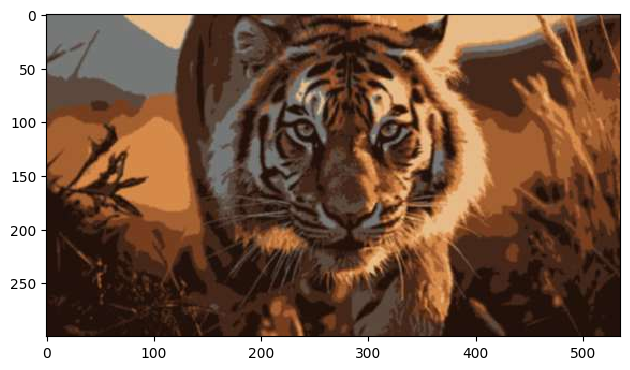

In [37]:
# 6. Display Final Compressed Image

image_final = io.imread(output_filename)
io.imshow(image_final)
io.show()

#### Analysis of My Advanced Approach

##### 1. **Downsampling (75%)**  
######   - I reduced the image resolution to 75% of its original size, which makes it easier to compress.  
######   - In my tests, this change had minimal impact on perceived quality, especially since the original image was sufficiently large.

##### 2. **K-Means Color Quantization (K=8)**  
######   - I constrained the image to just 8 distinct color clusters, which significantly cuts down color variability.  
######   - While this step usually improves compression, it can introduce banding or posterization in areas of smooth color transitions.

##### 3. **Gaussian Blur**  
######   - I applied a gentle Gaussian blur to smooth out the hard boundaries created by K-Means.  
######   - This helps JPEG compression because smoother gradients generally compress better, further reducing the final file size.

##### 4. **JPEG Quality (60)**  
######   - I saved the image at a quality of 60, aiming for a good balance between clarity and file size.  
######   - Lowering the quality can reduce file size further but at the cost of more visible artifacts.

##### **Result:**  
###### Using this combined strategy, I reduced the final image size **from 48.77 KB to 19.38 KB**, achieving a **significant** file size reduction with **acceptable** visual quality. I can still tweak any parameter—scaling factor, K value, blur intensity, or JPEG quality—to further optimize my trade-off between clarity and compression.
